# Setup

In [1]:
import os, sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
from tqdm import tqdm

project_root = os.path.dirname(os.getcwd())

In [2]:
import tensorflow as tf

# Set GPU memory growth before initializing TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled for all GPUs.")
    except RuntimeError as e:
        print("Failed to set memory growth:", e)

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
print("Is GPU available?", tf.config.list_physical_devices('GPU'))

# List all available devices
print("\nAvailable devices:")
for device in tf.config.list_physical_devices():
    print(device)

# Test if TensorFlow is using the GPU
try:
    with tf.device('/GPU:0'):
        print("\nRunning a simple computation on the GPU...")
        a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
        b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
        result = tf.matmul(a, b)
        print("Matrix multiplication result:\n", result)
except RuntimeError as e:
    print("Error using GPU:", e)


GPU memory growth enabled for all GPUs.
TensorFlow version: 2.16.2
Is GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Running a simple computation on the GPU...
Matrix multiplication result:
 tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


2025-01-11 18:30:56.103362: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-11 18:30:56.103392: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-11 18:30:56.103395: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-11 18:30:56.103596: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-11 18:30:56.103610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Load Image

In [2]:
target_size = (256, 256)

2025-01-12 15:38:57.641379: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-12 15:38:57.641414: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-12 15:38:57.641418: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-12 15:38:57.641437: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 15:38:57.641450: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


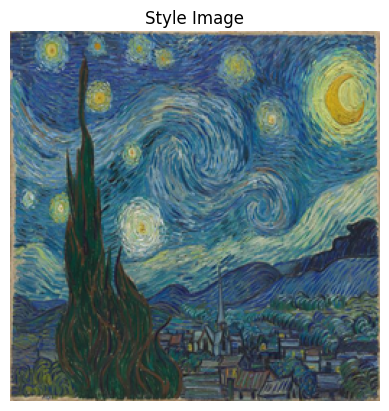

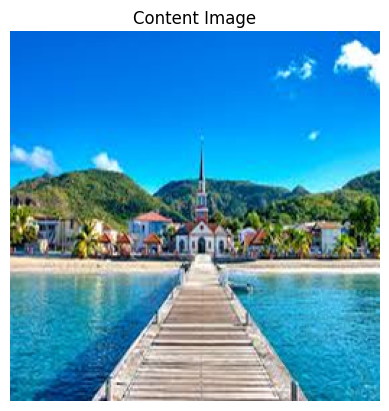

In [3]:
# Define a function to load and preprocess images
def load_image(image_path, target_size=(128, 128)):
    """
    Load an image, resize it, and preprocess it for neural network input.
    
    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Target size for the image, e.g., (128, 128).
    
    Returns:
        tf.Tensor: Preprocessed image tensor.
    """
    # Load the image
    image = Image.open(image_path).convert('RGB')  # Ensure 3 channels (RGB)
    
    # Resize the image
    image = image.resize(target_size, Image.LANCZOS)
    
    # Convert to a NumPy array and normalize pixel values
    image_array = np.array(image) / 255.0  # Scale pixel values to [0, 1]
    
    # Convert to a TensorFlow tensor
    image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
    
    # Add a batch dimension for processing in neural networks
    image_tensor = tf.expand_dims(image_tensor, axis=0)  # Shape: (1, 128, 128, 3)
    
    return image_tensor

# Display an image
def display_image(image_tensor, title="Image", clip_range=(0, 1)):
    """
    Display an image tensor.
    
    Args:
        image_tensor (tf.Tensor): Image tensor with shape (1, height, width, channels).
        title (str): Title of the plot.
        clip_range: (0, 1) or (0, 255)
    """
    # Remove the batch dimension and clip pixel values
    image = tf.squeeze(image_tensor, axis=0).numpy()  # Shape: (height, width, channels)
    image = np.clip(image, clip_range[0], clip_range[1])
    if clip_range==(0, 255):
        image = image.astype(np.uint8)
    
    # Plot the image
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.show()

# Paths to your images
style_image_path = os.path.join(project_root,"data/optimization_method/starry_night.jpg")  
content_image_path = os.path.join(project_root, "data/optimization_method/landscape.jpeg")

# Load and preprocess the images
style_image = load_image(style_image_path, target_size=target_size)
content_image = load_image(content_image_path, target_size=target_size)

# Display the images
display_image(style_image, title="Style Image")
display_image(content_image, title="Content Image")


# Pre-trained VGG

In [5]:
from tensorflow.keras.applications import VGG16

# Load a pre-trained VGG16 model
vgg = VGG16(include_top=False, weights='imagenet', input_shape=target_size + (3,))

for layer in vgg.layers:
    layer.trainable = False # Freeze the layers
    
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
def get_feature_extractor(pre_trained_model: tf.keras.Model, layer_names: list) -> tf.keras.Model:
    """
    Build a feature extractor model that returns intermediate layer outputs.
    
    Args:
        model (tf.keras.Model): The pretrained model to use as a feature extractor.
        layer_names (list): Names of the layers to use for feature extraction.
    
    Returns:
        tf.keras.Model: The feature extractor model.
    """
    # Get the intermediate layer outputs
    outputs = [pre_trained_model.get_layer(name).output for name in layer_names]
    
    # Build the feature extractor model
    return tf.keras.Model(inputs=pre_trained_model.input, outputs=outputs)

# Define the content and style layer names
content_layers = ["block4_conv2"]
style_layers = [ "block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]

# Instantiate feature extractor
feature_extractor = get_feature_extractor(vgg, content_layers + style_layers)


# Extract activation for given image
def get_activations(image, feature_extractor: tf.keras.Model) -> tuple:
    """
    Forward pass to get the activations of the content and style layers for an image.
    
    Args:
        image (tf.Tensor): Input image tensor.
        feature_extractor (tf.keras.Model): Feature extractor model.
    """
    
    preprocessed_image = tf.keras.applications.vgg16.preprocess_input(image * 255) # Useful for VGG
    
    # Get activations
    activations = feature_extractor(preprocessed_image)
    content_activations = activations[:len(content_layers)]
    style_activations = activations[len(content_layers):]
    
    del activations
    
    return content_activations, style_activations

# Model training

#### Loss

In [7]:
# Content Loss
def content_loss(content_activation: list[tf.Tensor], target_activation: list[tf.Tensor]) -> tf.Tensor:
    sum = 0
    n_elements = 0
    for c, t in zip(content_activation, target_activation):
        assert c.shape == t.shape, "Activations are different shape."
        sum += tf.math.reduce_sum(tf.math.square(c - t))
        n_elements += tf.size(c)
    
    return sum / tf.cast(n_elements, tf.float32)
    

# Style loss
def gram_matrix(activation: tf.Tensor) -> tf.Tensor:
    # Flatten
    transpose = tf.transpose(activation, perm=[0, 3, 1, 2])
    shape = tf.shape(transpose)
    reshaped = tf.reshape(transpose, [shape[0], shape[1], -1])
    
    return tf.matmul(reshaped, tf.transpose(reshaped, perm=[0, 2, 1]))


def style_loss(style_activations: list[tf.Tensor], target_activations: list[tf.Tensor]) -> tf.Tensor:
    # Gram matrices
    style_grams = [gram_matrix(style) for style in style_activations]
    target_grams = [gram_matrix(target) for target in target_activations]
    
    # MSE
    sum = 0
    n_elements = 0
    
    for m, n in zip(style_grams, target_grams):
        assert m.shape == n.shape, "Gram matrices are different shape."
        sum += tf.math.reduce_sum(tf.math.square(m - n))
        n_elements += tf.size(m)
        
    return sum / tf.cast(n_elements, tf.float32)

# Total variation loss
def total_loss(content_loss, style_loss, weights: dict) -> tf.Tensor:
    return weights['content'] * content_loss + weights['style'] * style_loss

weights = {
	'content' : 1,
	'style' : 1e3
}

#### Monitoring

In [8]:
# Function to save target image
# Function to save target image
def save_image(image_tensor, epoch, method="optimization_method", version="test"):
    """
    Save an image tensor to a file.
    
    Args:
        image_tensor (tf.Tensor): Image tensor with shape (1, height, width, channels).
        epoch (int): Current epoch number.
        method (str): The optimization method used.
        version (str): The version or configuration identifier.
    """
    image = tf.squeeze(image_tensor, axis=0).numpy()  # Remove batch dimension
    image = np.clip(image, 0, 1)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    
    # Define the directory and ensure it exists
    save_dir = os.path.join(project_root, f"models/ouputs_monitoring/{method}/{version}")
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
    
    # Construct file path
    file_path = os.path.join(save_dir, f"output_image_{epoch}.png")
    
    # Save the image
    tf.keras.utils.save_img(file_path, image)

#### Training

In [9]:
# Initialization
# Variable
target_image = tf.Variable(tf.identity(content_image), trainable=True) # Copy of content image

# Constants
feature_extractor = get_feature_extractor(vgg, content_layers + style_layers)

content_activations, _ = get_activations(content_image, feature_extractor)
_, style_activations = get_activations(style_image, feature_extractor)

weights = {'content' : 1, 'style' : 1e4} # Loss weights

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.99, epsilon=1e-7)

@tf.function
def train_step(target_image, content_activations: list[tf.Tensor], style_activations: list[tf.Tensor], weights: dict, 
               optimizer: tf.keras.optimizers.Optimizer, feature_extractor: tf.keras.Model):
    
    # record forward pass
    with tf.GradientTape() as tape:
        target_content, target_style = get_activations(target_image, feature_extractor)
        
        c_loss = content_loss(content_activations, target_content)
        s_loss = style_loss(style_activations, target_style)
        loss = total_loss(c_loss, s_loss, weights)
        
    # compute gradients
    gradients = tape.gradient(loss, target_image)
    
    # update weights
    optimizer.apply_gradients(zip([gradients], [target_image]))
    
    return loss

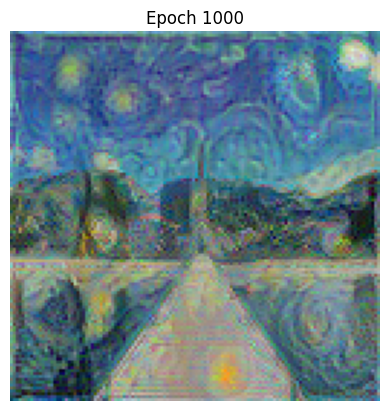

Image optimization: 100%|██████████| 1001/1001 [00:19<00:00, 50.84it/s]


In [10]:
# Training loop
n_epochs = 1000
for epoch in tqdm(range(n_epochs+1), desc="Image optimization"):
    loss = train_step(target_image, content_activations, style_activations, weights, optimizer, feature_extractor)
    
    if epoch % 250 == 0:
        #print(f"Epoch {epoch}: Loss: {loss}")
        clipped_image = tf.clip_by_value(target_image, 0., 1.)
        # Save image
        #save_image(clipped_image, epoch, method="optimization_method", version="maya")
        
        # Display image
        clear_output(wait=True)
        display_image(clipped_image, title=f"Epoch {epoch}")

In [11]:
def clear_monitoring_files(method="optimization_method", version="test"):
    import shutil
    path = os.path.join(project_root, f"models/ouputs_monitoring/{method}/{version}")
    shutil.rmtree(path)
    os.makedirs(path)
    
#clear_monitoring_files(version='maya2')

# Modular class

In [4]:
import sys
sys.path.append(project_root)
from models.test import StyleTransferModel, CONTENT_LAYERS, STYLE_LAYERS, get_feature_extractor, get_vgg

In [5]:
target_size = (256, 256)

In [6]:
# Instantiate model
feature_extractor = get_feature_extractor(get_vgg(input_shape=target_size), CONTENT_LAYERS + STYLE_LAYERS)
model = StyleTransferModel(feature_extractor=feature_extractor, target_size=target_size, learning_rate=1e-3)
weights = {
    "content": 1,
    "style": 1e5,
    "tv": 1e-6
} # Loss weights

In [7]:

# Load images
random_number = np.random.randint(0, 20000)
random_number = f"{random_number:05}"
content_image_path = os.path.join(project_root, f"data/coco2017/raw_images/0{random_number}.jpg")
content_image = load_image(content_image_path, target_size=(256,256))

style_image_path = os.path.join(project_root, "data/optimization_method/starry_night.jpg")
style_image = load_image(style_image_path, target_size=(256,256))

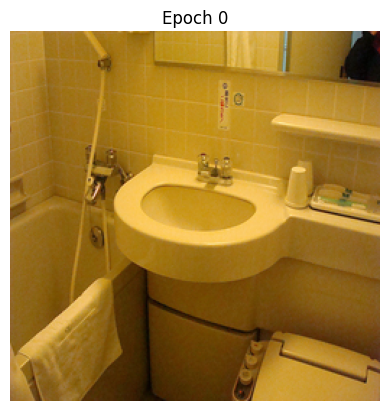

Image optimization:   0%|          | 1/501 [00:02<17:54,  2.15s/it]


AttributeError: in user code:

    File "/Users/theopinto--dalle/code/vision-style-transfer/models/test.py", line 133, in train_step  *
        self.optimizer.apply_gradients([(gradients, target_image)])
    File "/Users/theopinto--dalle/code/vision-style-transfer/env/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py", line 383, in apply_gradients  **
        self.apply(grads, trainable_variables)
    File "/Users/theopinto--dalle/code/vision-style-transfer/env/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py", line 424, in apply
        self._check_variables_are_known(trainable_variables)
    File "/Users/theopinto--dalle/code/vision-style-transfer/env/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py", line 328, in _check_variables_are_known
        if self._var_key(v) not in self._trainable_variables_indices:
    File "/Users/theopinto--dalle/code/vision-style-transfer/env/lib/python3.10/site-packages/keras/src/backend/tensorflow/optimizer.py", line 87, in _var_key
        return variable._unique_id

    AttributeError: 'SymbolicTensor' object has no attribute '_unique_id'


In [8]:
generated_image = model.fit(content_image, style_image, weights, n_epochs=500, version="cocotest", save=False)

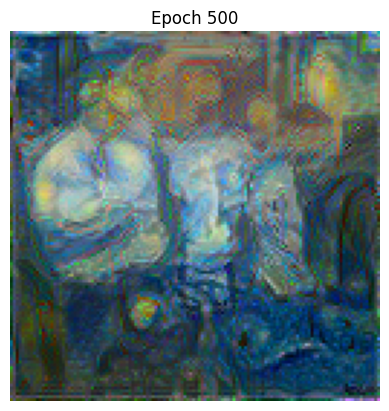

Image optimization: 100%|██████████| 501/501 [00:09<00:00, 53.22it/s]


In [73]:
generated_image = model.fit(content_image, style_image, weights, n_epochs=500, version="cocotest", save=False)

In [ ]:
# Save best hyperpar

# Colorimetry

In [15]:
# Load the generated image
if  generated_image is None:
    gen_im_path = os.path.join(project_root, "results/style_transfer/test/output_image_1500.png")
    generated_image = load_image(gen_im_path, target_size=target_size)

#### Method 1 - Histogram Matching

In [22]:
from skimage.exposure import match_histograms

def match_colors(generated_image, content_image):
    """
    Match the color distribution of the generated image to the content image.

    Args:
        generated_image (np.ndarray): Generated image as a NumPy array.
        content_image (np.ndarray): Content image as a NumPy array.

    Returns:
        np.ndarray: Color-transferred image.
    """
    matched_image = match_histograms(generated_image, content_image, channel_axis=-1)
    return matched_image

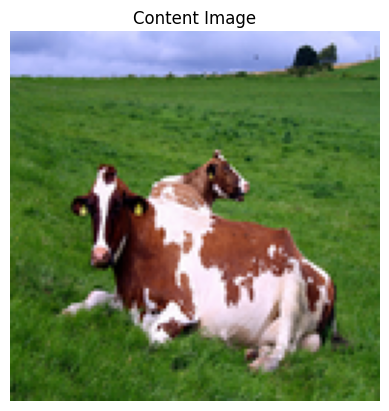

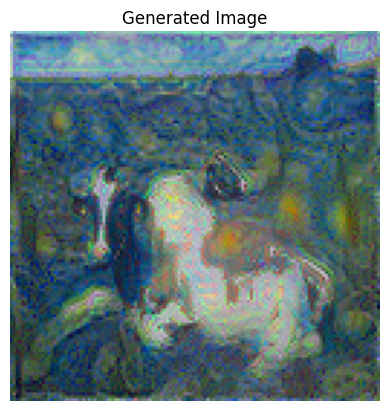

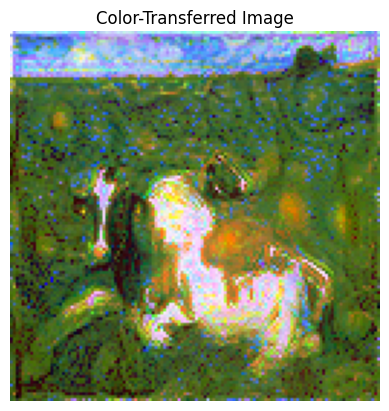

In [23]:
matched_image = match_colors(generated_image.numpy(), content_image.numpy())

# Display the images
display_image(content_image, title="Content Image")
display_image(generated_image, title="Generated Image")
display_image(matched_image, title="Color-Transferred Image")

#### Method 2 - Std

In [45]:
def match_mean_std(generated_image, content_image):
    """
    Adjust the mean and standard deviation of the generated image to match the content image.

    Args:
        generated_image (np.ndarray): Generated image as a NumPy array.
        content_image (np.ndarray): Content image as a NumPy array.

    Returns:
        np.ndarray: Color-matched image.
    """
    for channel in range(3):  # Assuming RGB
        gen_mean, gen_std = generated_image[..., channel].mean(), generated_image[..., channel].std()
        cont_mean, cont_std = content_image[..., channel].mean(), content_image[..., channel].std()
        generated_image[..., channel] = (
            (generated_image[..., channel] - gen_mean) / (gen_std + 1e-8)
        ) * cont_std + cont_mean
    return np.clip(generated_image, 0, 1)  # Ensure valid pixel range

In [ ]:
matched_image = match_mean_std(generated_image.numpy(), content_image.numpy())

# Display the images
display_image(content_image, title="Content Image")
display_image(generated_image, title="Generated Image")
display_image(matched_image, title="Color-Transferred Image")

# Super-Resolution

In [29]:
import tensorflow_hub as hub

%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  print(f"original_image :\n{image}")
  image = np.asarray(image)
  print(f"np.asarray :\n{image}")
  image = tf.clip_by_value(image, 0, 255)
  print(f"tf.clip_by_value :\n{image}")
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  print(f"Image.fromarray :\n{image}")
  #plt.imshow(image)
  #plt.axis("off")
  #plt.title(title)

In [30]:
# Load pre-trained Super-Resolution model from TensorFlow Hub
sr_model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")

In [31]:
sr_image = tf.clip_by_value(generated_image, 0, 1)
#clip values
sr_image = sr_image * 255
output_image = sr_model(sr_image)

In [38]:
output_image[0, :, :, 0].numpy().max()

329.93448

In [39]:
def super_resolution(image:tf.Tensor, model) -> tf.Tensor:
    # scale to [0, 255] if needed
    if image[0, :, :, 0].numpy().max() <= 1:
        image = tf.clip_by_value(image, 0, 1)
        image = image * 255
    return model(image)

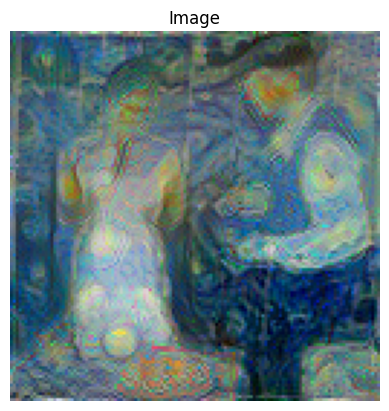

In [34]:
display_image(generated_image)

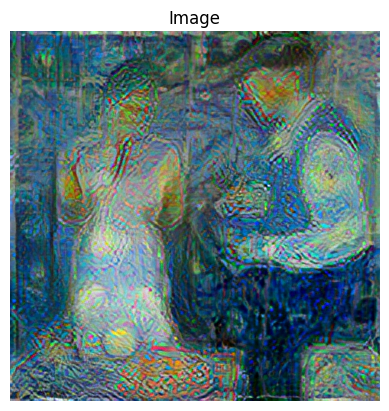

In [41]:
display_image(super_resolution(output_image, sr_model), clip_range=(0, 255))